In [54]:
#check whether cuda is enabled or not
import torch

print("Number of GPU: ", torch.cuda.device_count())
print("GPU Name: ", torch.cuda.get_device_name())

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Number of GPU:  0


RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [2]:
from huggingface_hub import notebook_login

In [3]:
from datasets import load_dataset #65
from evaluate import load #55

In [4]:
import wandb
import pandas as pd
import numpy as np
import re
import json
from sklearn.model_selection import train_test_split
import random
from IPython.display import display, HTML
import torchaudio 

In [5]:
wandb.login(key="0e7280bb2e4bfc81c8c0b019860ef8f11041f4d4") # add wandb API key

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /teamspace/studios/this_studio/.netrc
wandb: Currently logged in as: 770310 (770310-khwopa-engineering-college) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [6]:
wandb.init(project="speech")

In [7]:
!mkdir csv_files
!mkdir trained_models
!mkdir checkpoints
!mkdir tokenizer 
!mkdir processor 
!mkdir feature_extractor

mkdir: cannot create directory ‘csv_files’: File exists


mkdir: cannot create directory ‘trained_models’: File exists
mkdir: cannot create directory ‘checkpoints’: File exists
mkdir: cannot create directory ‘tokenizer’: File exists
mkdir: cannot create directory ‘processor’: File exists


In [8]:
csv_folder_path = '/teamspace/studios/this_studio/csv_files'
trained_model_path = '/teamspace/studios/this_studio/trained_models/wav2vec0.8dropout'
processor_path = '/teamspace/studios/this_studio/processor/wav2vec0.8dropout'
checkpoints_path = '/teamspace/studios/this_studio/checkpoints/'
tokenizer_path = '/teamspace/studios/this_studio/tokenizer/'
feature_extractor_path = '/teamspace/studios/this_studio/feature_extractor/'

In [9]:
colnames = ["path","labels"]
audio_path = '/teamspace/studios/this_studio/training_data/audio/'
transcript_path = '/teamspace/studios/this_studio/training_data/split_1.csv'
df = pd.read_csv(transcript_path,usecols=colnames)
df["path"] = audio_path + df["path"] + ".wav"
print(df.shape)
df.head()

(5000, 2)


,path,labels
0,/teamspace/studios/this_studio/training_data/a...,कुनै शाखामा
1,/teamspace/studios/this_studio/training_data/a...,बजे उठेर घरबाट
2,/teamspace/studios/this_studio/training_data/a...,तयारीमा समिति लागेको
3,/teamspace/studios/this_studio/training_data/a...,रानी हुन्
4,/teamspace/studios/this_studio/training_data/a...,जहाँनिया राणाशासनले देशभक्त


In [10]:
TEST_RATIO = 0.90 
VAL_RATIO = 0.75

In [11]:
train_df, test_df = train_test_split(df, random_state = 0, train_size = TEST_RATIO)
train_df, val_df = train_test_split(train_df, random_state = 0, train_size = VAL_RATIO)


In [12]:
train_df.to_csv(csv_folder_path+'/train.csv',index=False)
val_df.to_csv(csv_folder_path+'/val.csv',index=False)
test_df.to_csv(csv_folder_path+'/test.csv',index=False)

In [13]:
data_files = {
    "train": "train.csv",
    "validation": "val.csv",
    "test": "test.csv"
}

In [14]:
train_data = load_dataset(csv_folder_path, data_files = data_files, split = "train")
val_data = load_dataset(csv_folder_path, data_files = data_files, split = "validation")

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [15]:
import pandas as pd

# Load the train, val, and test CSV files from split_1 and split_2
train_split_1 = pd.read_csv('/teamspace/studios/this_studio/csv_files/train1.csv')
val_split_1 = pd.read_csv('/teamspace/studios/this_studio/csv_files/val1.csv')
test_split_1 = pd.read_csv('/teamspace/studios/this_studio/csv_files/test1.csv')

train_split_2 = pd.read_csv('/teamspace/studios/this_studio/csv_files/train.csv')
val_split_2 = pd.read_csv('/teamspace/studios/this_studio/csv_files/val.csv')
test_split_2 = pd.read_csv('/teamspace/studios/this_studio/csv_files/test.csv')

# Concatenate the corresponding CSV files
merged_train_df = pd.concat([train_split_1, train_split_2], ignore_index=True)
merged_val_df = pd.concat([val_split_1, val_split_2], ignore_index=True)
merged_test_df = pd.concat([test_split_1, test_split_2], ignore_index=True)

# Save the merged DataFrames to new CSV files
merged_train_df.to_csv('/teamspace/studios/this_studio/merged_csvs/merged_train.csv', index=False)
merged_val_df.to_csv('/teamspace/studios/this_studio/merged_csvs/merged_val.csv', index=False)
merged_test_df.to_csv('/teamspace/studios/this_studio/merged_csvs/merged_test.csv', index=False)

# Verify the size of the merged CSV files
print(f'Merged train CSV contains {merged_train_df.shape[0]} rows.')
print(f'Merged val CSV contains {merged_val_df.shape[0]} rows.')
print(f'Merged test CSV contains {merged_test_df.shape[0]} rows.')


FileNotFoundError: [Errno 2] No such file or directory: '/teamspace/studios/this_studio/csv_files/train1.csv'

In [16]:
def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = pd.DataFrame(dataset[picks])
    display(HTML(df.to_html()))

In [17]:
# chars_to_ignore = '[\,\?\.\!\-\;\:\"\“\%\‘\”\ ]'
chars_to_ignore = r'[\,\?\.\!\-\;\:\"\“\%\‘\”\ ]'

In [18]:
def remove_special_characters(batch):
    batch["labels"] = re.sub(chars_to_ignore, '', batch["labels"]).lower() + " "
    return batch

In [19]:
train_data = train_data.map(remove_special_characters)
val_data = val_data.map(remove_special_characters)

Map:   0%|          | 0/3375 [00:00<?, ? examples/s]

Map:   0%|          | 0/1125 [00:00<?, ? examples/s]

In [20]:
unique_letters = {
    "[PAD]": 0,
    "[UNK]": 1,
    "|": 2,
    " ": 3,  # Added space
    "क": 4,
    "ख": 5,
    "ग": 6,
    "घ": 7,
    "ङ": 8,
    "च": 9,
    "छ": 10,
    "ज": 11,
    "झ": 12,
    "ञ": 13,
    "ट": 14,
    "ठ": 15,
    "ड": 16,
    "ढ": 17,
    "ण": 18,
    "त": 19,
    "थ": 20,
    "द": 21,
    "ध": 22,
    "न": 23,
    "प": 24,
    "फ": 25,
    "ब": 26,
    "भ": 27,
    "म": 28,
    "य": 29,
    "र": 30,
    "ल": 31,
    "व": 32,
    "श": 33,
    "ष": 34,
    "स": 35,
    "ह": 36,
    "क्ष": 37,
    "त्र": 38,
    "ज्ञ": 39,
    "अ": 40,
    "आ": 41,
    "इ": 42,
    "ई": 43,
    "उ": 44,
    "ऊ": 45,
    "ए": 46,
    "ऐ": 47,
    "ओ": 48,
    "औ": 49,
    "अं": 50,
    "अः": 51,
    "ा": 52,
    "ि": 53,
    "ी": 54,
    "ु": 55,
    "ू": 56,
    "े": 57,
    "ै": 58,
    "ो": 59,
    "ौ": 60,
    "ं": 61,
    "ः": 62,
    "ँ": 63,
    "०": 64,
    "१": 65,
    "२": 66,
    "३": 67,
    "४": 68,
    "५": 69,
    "६": 70,
    "७": 71,
    "८": 72,
    "९": 73,
    "्": 74, # Halant (virama)
    "ऱ्": 75, 
    "ृ": 76
}


In [21]:
# Save to JSON format
output_file = "/teamspace/studios/this_studio/input/cleaned-asr-data/data/vocabulary/vocab.json"
with open(output_file, "w", encoding="utf-8") as f:
    json.dump(unique_letters, f, ensure_ascii=False, indent=4)

print(f"Unique letters saved to {output_file}")

Unique letters saved to /teamspace/studios/this_studio/input/cleaned-asr-data/data/vocabulary/vocab.json


In [22]:
import os
from transformers import Trainer, TrainingArguments, Wav2Vec2ForCTC, Wav2Vec2CTCTokenizer, Wav2Vec2FeatureExtractor, Wav2Vec2Processor, AutoTokenizer

# Set environment variable to handle fragmentation
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# Define model and arguments
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-large-xlsr-53")
model.gradient_checkpointing_enable()  # Enable gradient checkpointing

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-xlsr-53 and are newly initialized: ['lm_head.bias', 'lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
vocab_path = './input/cleaned-asr-data/data/vocabulary/vocab.json'
tokenizer = Wav2Vec2CTCTokenizer(
    vocab_path, 
    unk_token = "[UNK]", 
    pad_token = "[PAD]", 
    word_delimiter_token = "|"
)

In [24]:
tokenizer.save_pretrained(tokenizer_path)

('/teamspace/studios/this_studio/tokenizer/tokenizer_config.json',
 '/teamspace/studios/this_studio/tokenizer/special_tokens_map.json',
 '/teamspace/studios/this_studio/tokenizer/vocab.json',
 '/teamspace/studios/this_studio/tokenizer/added_tokens.json')

In [25]:
feature_extractor = Wav2Vec2FeatureExtractor(
    feature_size = 1, 
    sampling_rate = 16000, 
    padding_value = 0.0, 
    do_normalize = True, 
    return_attention_mask = True
)

In [26]:
processor = Wav2Vec2Processor(
    feature_extractor = feature_extractor, 
    tokenizer = tokenizer
)

In [27]:
processor.save_pretrained(processor_path)
# tokenizer= AutoTokenizer.from_pretrained("your-model-name")
# tokenizer.save_pretrained("path/to/save/tokenizer")

[]

In [28]:
torch.__version__

'2.6.0+cu124'

In [29]:
def speech_file_to_array_fn(batch):
    speech_array, sampling_rate = torchaudio.load(batch["path"])
    batch["speech"] = speech_array[0].numpy()
    batch["sampling_rate"] = sampling_rate
    batch["target_text"] = batch["labels"]
    
    resampler = torchaudio.transforms.Resample(sampling_rate, 16000)
    batch["speech"] = resampler(speech_array).squeeze().numpy()
    batch["sampling_rate"] = 16000
    
    return batch

In [30]:
# %pip install librosa soundfile torchaudio


In [31]:
train_data = train_data.map(speech_file_to_array_fn, remove_columns=train_data.column_names)
val_data = val_data.map(speech_file_to_array_fn, remove_columns=val_data.column_names)

Map:   0%|          | 0/3375 [00:00<?, ? examples/s]

Map:   0%|          | 0/1125 [00:00<?, ? examples/s]

In [32]:
from IPython.display import Audio  # Import the Audio class

In [33]:
rand_int = random.randint(0, len(train_data) - 1)

In [34]:
 train_data[rand_int]["target_text"]

'सिकारखेल्नजान्थे '

In [35]:
def prepare_dataset(batch, processor):
        
    # check that all files have the correct sampling rate
    assert (
        len(set(batch["sampling_rate"])) == 1
    ), f"Make sure all inputs have the same sampling rate of {processor.feature_extractor.sampling_rate}."

    batch["input_values"] = processor(batch["speech"], sampling_rate = batch["sampling_rate"][0]).input_values
    
    with processor.as_target_processor():
        batch["labels"] = processor(batch["target_text"]).input_ids
    return batch

In [36]:
train_data = train_data.map(prepare_dataset, fn_kwargs = {"processor": processor}, remove_columns = train_data.column_names, batch_size = 8, num_proc = 4, batched = True)
val_data = val_data.map(prepare_dataset, fn_kwargs = {"processor": processor}, remove_columns = val_data.column_names, batch_size = 8, num_proc = 4, batched = True)

Map (num_proc=4):   0%|          | 0/3375 [00:00<?, ? examples/s]

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers

Map (num_proc=4):   0%|          | 0/1125 [00:00<?, ? examples/s]

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers

In [37]:
from dataclasses import dataclass
from typing import Any, Dict, List, Optional, Union

In [38]:
@dataclass
class DataCollatorCTCWithPadding:
    """
    Data collator that will dynamically pad the inputs received.
    Args:
        processor (:class:`~transformers.Wav2Vec2Processor`)
            The processor used for proccessing the data.
        padding (:obj:`bool`, :obj:`str` or :class:`~transformers.tokenization_utils_base.PaddingStrategy`, `optional`, defaults to :obj:`True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch (or no padding if only a single
              sequence if provided).
            * :obj:`'max_length'`: Pad to a maximum length specified with the argument :obj:`max_length` or to the
              maximum acceptable input length for the model if that argument is not provided.
            * :obj:`False` or :obj:`'do_not_pad'` (default): No padding (i.e., can output a batch with sequences of
              different lengths).
        max_length (:obj:`int`, `optional`):
            Maximum length of the ``input_values`` of the returned list and optionally padding length (see above).
        max_length_labels (:obj:`int`, `optional`):
            Maximum length of the ``labels`` returned list and optionally padding length (see above).
        pad_to_multiple_of (:obj:`int`, `optional`):
            If set will pad the sequence to a multiple of the provided value.
            This is especially useful to enable the use of Tensor Cores on NVIDIA hardware with compute capability >=
            7.5 (Volta).
    """

    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True
    max_length: Optional[int] = None
    max_length_labels: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    pad_to_multiple_of_labels: Optional[int] = None

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lenghts and need
        # different padding methods
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )
        with self.processor.as_target_processor():
            labels_batch = self.processor.pad(
                label_features,
                padding=self.padding,
                max_length=self.max_length_labels,
                pad_to_multiple_of=self.pad_to_multiple_of_labels,
                return_tensors="pt",
            )

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        batch["labels"] = labels

        return batch

In [39]:
data_collator = DataCollatorCTCWithPadding(processor = processor, padding = True)

In [40]:
wer_metric = load("wer")
cer_metric = load("cer")

In [41]:
# model = Wav2Vec2ForCTC.from_pretrained(
#     "facebook/wav2vec2-large-xlsr-53", 
#     attention_dropout = 0.1,
#     hidden_dropout = 0.1,
#     feat_proj_dropout = 0.0,
#     mask_time_prob = 0.05,
#     layerdrop = 0.1,
#     gradient_checkpointing = True, 
#     ctc_loss_reduction = "mean", 
#     pad_token_id = processor.tokenizer.pad_token_id,
#     vocab_size = len(processor.tokenizer)
# )

# for checkpoint
model = Wav2Vec2ForCTC.from_pretrained("/teamspace/studios/this_studio/checkpoints/checkpoint-6541")

In [42]:
model.freeze_feature_encoder()

In [43]:
def compute_metrics(pred):
    pred_logits = pred.predictions
    pred_ids = np.argmax(pred_logits, axis=-1)

    pred.label_ids[pred.label_ids == -100] = processor.tokenizer.pad_token_id

    pred_str = processor.batch_decode(pred_ids)
    # we do not want to group tokens when computing the metrics
    label_str = processor.batch_decode(pred.label_ids, group_tokens=False)

    wer = wer_metric.compute(predictions=pred_str, references=label_str)
    cer = cer_metric.compute(predictions=pred_str, references=label_str)
    
    # cer_best = 1 - cer because load best model is considering greater value of cer for better results
    cer_best = 1 - cer
    # wandb.log({'wer':wer, 'cer':cer})
    # experiment.log_metric('wer', wer)
    # experiment.log_metric('cer', cer)
    
    return {"wer": wer, "cer": cer, "cer_best": cer_best}


In [44]:
import accelerate
# print("Transformers version:", transformers.__version__)
# print("Accelerate version:", accelerate.__version__)
# print("PyTorch version:", torch.__version__)
# print("CUDA available:", torch.cuda.is_available())

In [45]:
from transformers import TrainingArguments

In [46]:
training_args = TrainingArguments(
    output_dir="/teamspace/studios/this_studio/checkpoints",  # Path to save training checkpoints
    resume_from_checkpoint=True,  # Resume from the latest checkpoint
    per_device_train_batch_size=8,
    gradient_accumulation_steps=2,
    num_train_epochs=31,
    fp16=True,
    save_steps=300,
    eval_steps=300,
    logging_steps=300,
    learning_rate=3e-4,
    warmup_steps=180,
    save_total_limit=2,
    gradient_checkpointing=True,
)

In [47]:
from transformers import Trainer

In [49]:
from transformers import TrainingArguments, Trainer, TrainerCallback
import matplotlib.pyplot as plt

# Define the custom MetricsCallback
class MetricsCallback(TrainerCallback):
    def __init__(self):
        self.train_loss = []
        self.val_loss = []
        self.epochs = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        # Capture metrics during training
        if logs is not None:
            if "loss" in logs:
                self.train_loss.append(logs["loss"])
            if "eval_loss" in logs:
                self.val_loss.append(logs["eval_loss"])
            if "epoch" in logs:
                self.epochs.append(logs["epoch"])

In [50]:
# Instantiate the callback
metrics_callback = MetricsCallback()

In [51]:

# Create the Trainer
trainer = Trainer(
    model=model,  # Your model
    data_collator=data_collator,  # Data collator for batching
    args=training_args,  # Training arguments
    compute_metrics=compute_metrics,  # Function to compute metrics
    train_dataset=train_data,  # Training dataset
    eval_dataset=val_data,  # Evaluation dataset
    # tokenizer=processor.feature_extractor,  # Tokenizer/processor
    callbacks=[metrics_callback],  # Add custom callback
    processing_class=processor  # Use processing_class

)

In [52]:
trainer.accelerator.scaler = torch.cuda.amp.GradScaler()

/tmp/ipykernel_1450/2984383469.py:1: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  trainer.accelerator.scaler = torch.cuda.amp.GradScaler()
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


In [ ]:
trainer.train()

# trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(


Step,Training Loss


KeyboardInterrupt: 

In [82]:
trainer.save_model(trained_model_path)

In [83]:
#  Optionally, evaluate final model
final_metrics = trainer.evaluate()
print(f"Final WER: {final_metrics['eval_wer'] * 100:.2f}%")
print(f"Final CER: {final_metrics['eval_cer'] * 100:.2f}%")

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(


Final WER: 80.98%
Final CER: 13.94%


In [82]:
# After training, compute final metrics
metrics = trainer.evaluate()

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(


In [86]:
# Added: How to find loss, error, and accuracy
print("\n==== Final Model Evaluation ====")
print(f"Final WER (Word Error Rate): {metrics['eval_wer'] * 100:.2f}%")
print(f"Final CER (Character Error Rate): {metrics['eval_cer'] * 100:.2f}%")
print(f"Final Validation Loss: {metrics['eval_loss']:.4f}")


==== Final Model Evaluation ====


NameError: name 'metrics' is not defined

In [87]:
# Added: Calculate Accuracy (1 - WER and 1 - CER)
word_accuracy = (1 - metrics['eval_wer']) * 100
char_accuracy = (1 - metrics['eval_cer']) * 100
print(f"Word-Level Accuracy: {word_accuracy:.2f}%")
print(f"Character-Level Accuracy: {char_accuracy:.2f}%")


NameError: name 'metrics' is not defined

In [88]:
# Ensure loss visualization includes the final evaluation
# Prepare data for plotting
epochs = metrics_callback.epochs
train_loss = metrics_callback.train_loss
val_loss = metrics_callback.val_loss

In [89]:
# Ensure lengths match for plotting
min_length = min(len(epochs), len(train_loss), len(val_loss))
epochs = epochs[:min_length]
train_loss = train_loss[:min_length]
val_loss = val_loss[:min_length]

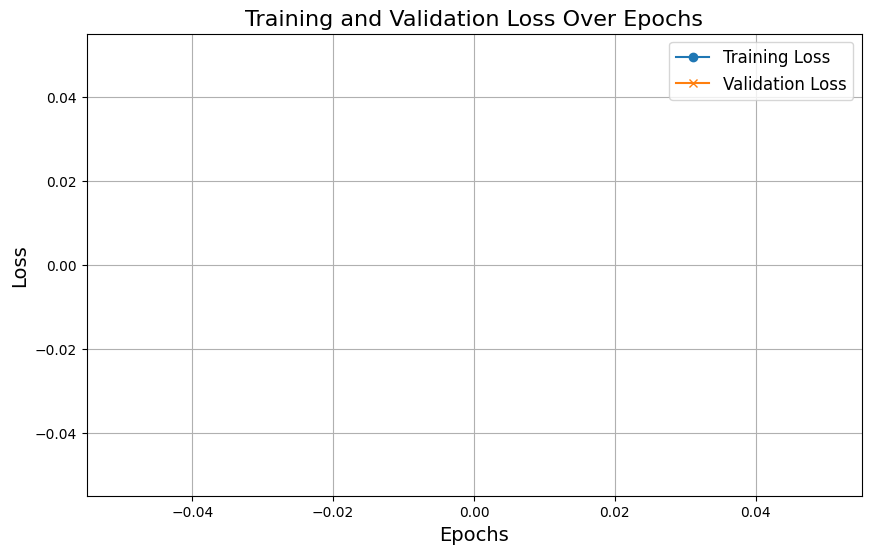

In [90]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label="Training Loss", marker="o")
plt.plot(epochs, val_loss, label="Validation Loss", marker="x")
plt.title("Training and Validation Loss Over Epochs", fontsize=16)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Define the path for split_2.csv
split_2_path = "/teamspace/studios/this_studio/training_data/split_2.csv"

# Load the data from split_2.csv
split_2_df = pd.read_csv(split_2_path)

# Split the data from split_2.csv into train, validation, and test sets
TEST_RATIO = 0.10  # Test size
VAL_RATIO = 0.75   # Validation size (of the train set)
train_df, test_df = train_test_split(split_2_df, test_size=TEST_RATIO, random_state=0)
train_df, val_df = train_test_split(train_df, test_size=VAL_RATIO, random_state=0)

# Save these splits into new CSV files
split_2_train_csv = "/teamspace/studios/this_studio/training_data/split_2_train.csv"
split_2_val_csv = "/teamspace/studios/this_studio/training_data/split_2_val.csv"
split_2_test_csv = "/teamspace/studios/this_studio/training_data/split_2_test.csv"

train_df.to_csv(split_2_train_csv, index=False)
val_df.to_csv(split_2_val_csv, index=False)
test_df.to_csv(split_2_test_csv, index=False)

# Now load the existing train.csv, val.csv, and test.csv (from split_1 or previous training)
existing_train_path = "/teamspace/studios/this_studio/csv_files/train.csv"
existing_val_path = "/teamspace/studios/this_studio/csv_files/val.csv"
existing_test_path = "/teamspace/studios/this_studio/csv_files/test.csv"

# Read the existing data
existing_train_df = pd.read_csv(existing_train_path)
existing_val_df = pd.read_csv(existing_val_path)
existing_test_df = pd.read_csv(existing_test_path)

# Merge the new data from split_2.csv with the existing datasets
merged_train_df = pd.concat([existing_train_df, train_df], ignore_index=True)
merged_val_df = pd.concat([existing_val_df, val_df], ignore_index=True)
merged_test_df = pd.concat([existing_test_df, test_df], ignore_index=True)

# Save the merged datasets back to their respective CSV files
merged_train_df.to_csv(existing_train_path, index=False)
merged_val_df.to_csv(existing_val_path, index=False)
merged_test_df.to_csv(existing_test_path, index=False)

print("✅ Merged split_2 data with existing datasets successfully!")


✅ Merged split_2 data with existing datasets successfully!
